In [21]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
import ROOT as r
import time
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

Welcome to JupyROOT 6.26/00


In [3]:
def fit(nsamples,nbins,start): #define starting index
    cols=[f'toybin{i:04d}' for i in range(start,start+nbins)]
    diagnostics_df=pd.DataFrame(columns=cols,index=['sigma_median','mcse','rhat'])
    sigma_df=pd.DataFrame(columns=cols)
    for i in range(start,start+nbins):#no. of toy bins
        #read data
        df=pd.read_csv(f"toybins/toybin{i:04d}.txt",sep="\t")
        #df=pd.read_csv(f"new_toy_MC.txt",sep="\t")
        df.columns=['pol','phi','weight']
        #these are prompt peak events
        prmpt=df.loc[df['weight']==1]
        prmpt=prmpt.reset_index(drop=True)
        #sideband
        side=df.loc[df['weight']!=1]
        side=side.reset_index(drop=True)
        nprmpt=len(prmpt)
        total_nside=(len(side))
        #weights used in the data, including 1--> exterminate 1
        weights=pd.unique(df['weight'].values)
        weights=np.array(weights[weights!=1])
        #sideband events are identified by the corresponding weights
        nside=np.array([len(df.loc[df['weight']==weights[i]])for i in range(len(weights))])
        #fraction of signal in prompt peak, note that the weights are already negative (TO BE CHECKED W/ FARAHS DATA!)
        f=(nprmpt+np.sum(nside*weights))/nprmpt
        print(f)
        stan_data={
            'N':nprmpt, #no. of prompt peak events and corresponding pol and phi values
            'phi_prmpt':list(prmpt['phi'].values),
            'pol_prmpt':list(prmpt['pol'].values),
            'M':total_nside,#no. of sideband events and..
            'phi_side':list(side['phi'].values),
            'pol_side':list(side['pol'].values),
            'f':f #fraction of signal in prmpt peak
        }
        print(nprmpt, total_nside)
        #now the stan model and mcmc
        model=sp.CmdStanModel(stan_file='toyMC_stan.stan')
        model.compile()
        fitobj=model.sample(data=stan_data,iter_sampling=nsamples,inits=0)
        summary=fitobj.summary()
        samples=fitobj.draws_pd()
        #get mcmc diagnostics
        median=summary['50%']['sigma']
        mcse=(az.mcse(np.transpose(fitobj.draws(concat_chains=False)[:,:,7]),method='median'))
        rhat=(summary['R_hat']['sigma'])
        tmp_list=[median,mcse,rhat]
        currbin=f"toybin{i:04d}"
        diagnostics_df[currbin]=tmp_list
        sigma_df[currbin]=samples['sigma']
    return diagnostics_df, sigma_df, summary

In [3]:
dfs=fit(nsamples=1000,nbins=100,start=100)
diagnostics=dfs[0]
sigma=dfs[1]
diagnostics.to_csv('toy_diagnostics_01.csv')
sigma.to_csv('toy_sigma_01.csv')

0.9498084448823207
1827 2397


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

ERROR:cmdstanpy:Chain [2] error: terminated by signal 2 Unknown error: -2
ERROR:cmdstanpy:Chain [3] error: terminated by signal 2 Unknown error: -2
ERROR:cmdstanpy:Chain [1] error: terminated by signal 2 Unknown error: -2
ERROR:cmdstanpy:Chain [4] error: terminated by signal 2 Unknown error: -2


KeyboardInterrupt: 

In [11]:
sigma_df_0=pd.read_csv('toy_sigma_00.csv',index_col=0)
diagnostics_df_0=pd.read_csv('toy_diagnostics_00.csv',index_col=0)
sigma_df_1=pd.read_csv('toy_sigma_01.csv',index_col=0)
diagnostics_df_1=pd.read_csv('toy_diagnostics_01.csv',index_col=0)
sigma_df=sigma_df_0.join(sigma_df_1)
diagnostics_df=diagnostics_df_0.join(diagnostics_df_1)
diagnostics_df

,toybin0000,toybin0001,toybin0002,toybin0003,toybin0004,toybin0005,toybin0006,toybin0007,toybin0008,toybin0009,...,toybin0190,toybin0191,toybin0192,toybin0193,toybin0194,toybin0195,toybin0196,toybin0197,toybin0198,toybin0199
sigma_median,0.630000,0.600000,0.570000,0.340000,0.470000,0.640000,0.490000,0.550000,0.470000,0.300000,...,0.420000,0.500000,0.250000,0.540000,0.500000,0.530000,0.45000,0.480000,0.540000,0.440000
mcse,0.002066,0.002075,0.001668,0.001962,0.002053,0.002133,0.002194,0.001785,0.001577,0.002223,...,0.001682,0.001856,0.002576,0.002757,0.002027,0.002667,0.00275,0.002256,0.001701,0.001833
rhat,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [17]:
sigma_df.to_csv('toy_sigma.csv')
diagnostics_df.to_csv('toy_diagnostics.csv')

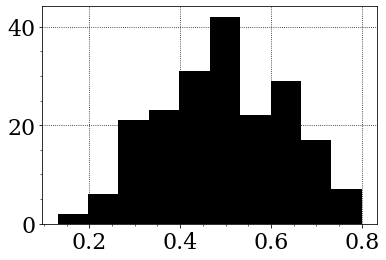

In [12]:

medians=[(diagnostics_df[f'toybin{i:04d}']['sigma_median']) for i in range(0,200)]
plt.hist(medians)
plt.show()

In [30]:
all_sigmas=[]
for i in range(200):
    all_sigmas.extend((np.array(sigma_df[f'toybin{i:04d}'].values)-0.5)/np.std(sigma_df[f'toybin{i:04d}'].values))

In [31]:
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
mu=np.mean(all_sigmas)
sigma=np.std(all_sigmas)

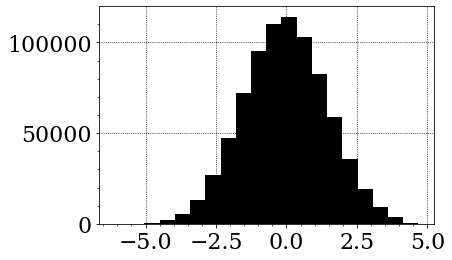

In [32]:
plt.hist(all_sigmas,bins=20)
plt.show()

In [33]:
h=r.TH1D("h","h",100,-5,5)
for i in range(len(all_sigmas)):
    h.Fill(all_sigmas[i])
    

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [34]:
c=r.TCanvas()
c.Draw("")
h.Draw("")
h.Fit("gaus")

 FCN=1615.88 FROM MIGRAD    STATUS=CONVERGED      59 CALLS          60 TOTAL
                     EDM=1.30084e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.16994e+04   2.92847e+01   4.76878e-01   1.57666e-06
   2  Mean        -5.14072e-02   1.65394e-03   3.24683e-05  -1.69420e-02
   3  Sigma        1.46886e+00   1.12024e-03   4.13836e-06   2.56810e-02
/usr/include/c++/11.2.0/bits/shared_ptr_base.h:979: std::__shared_ptr_access<_Tp, _Lp, <anonymous>, <anonymous> >::element_type& std::__shared_ptr_access<_Tp, _Lp, <anonymous>, <anonymous> >::operator*() const [with _Tp = TFitResult; __gnu_cxx::_Lock_policy _Lp = __gnu_cxx::_S_atomic; bool <anonymous> = false; bool <anonymous> = false; std::__shared_ptr_access<_Tp, _Lp, <anonymous>, <anonymous> >::element_type = TFitResult]: Assertion '_M_get() != nullptr' failed.
/usr/includ

Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
 *** Break *** abort
 Generating stack trace...
 0x00007fd35fed54b8 in raise at :? from /usr/lib/libc.so.6
 0x00007fd35febf534 in abort at :? from /usr/lib/libc.so.6
 0x00007fd2fb0090be in TFitResultPtr::operator*() const + 0x5e from /usr/lib/root/libHist.so
 0x00007fd2fbf9a024 in <unknown function>
 0x00007fd301818f47 in <unknown> from /usr/lib/root/libcppyy_backend3_10.so
 0x00007fd30181a534 in Cppyy::CallR(long, void*, unsigned long, void*) + 0x34 from /usr/lib/root/libcppyy_backend3_10.so
 0x00007fd3018dc9e4 in <unknown> from /usr/lib/python3.10/site-packages/libcppyy3_10.so
 0x00007fd3018c22a6 in <unknown> from /usr/lib/python3.10/site-packages/libcppyy3_10.so
 0x00007fd3018c4dc0 in CPyCppyy::CPPMethod::ExecuteProtected(void*, long, CPyCppyy::CallContext*) + 0x120 from /usr/lib/python3.10/site-packages/libcppyy3_10.so
 0x00007fd3018c34ef in CPyCppyy::CPPMethod::Execute(void*, long, CPyCppyy::CallContext*) + 0x2f 

In [35]:
c.SaveAs("combined_post_add.pdf")

Info in <TCanvas::Print>: pdf file combined_post_add.pdf has been created


In [54]:
#read data
i=10 # define which bin to use
df=pd.read_csv(f"toybins/toybin{i:04d}.txt",sep="\t")
df.columns=['pol','phi','weight']
#select only prmpt events
p45=df.loc[(df['weight']==1)&(df['pol']>0)].reset_index(drop=True)
m45=df.loc[(df['weight']==1)&(df['pol']<0)].reset_index(drop=True)
hp45=r.TH1F("p45","p45",24,-180,180)
hm45=r.TH1F("m45","m45",24,-180,180)
#histogram them
for i in p45['phi'].values:
    hp45.Fill(i)
for i in m45['phi'].values:
    hm45.Fill(i)
#normalize    
norm_p = 1./hp45.Integral()
norm_m = 1./hm45.Integral()
hp45.Scale(norm_p)
hm45.Scale(norm_m)
#build polarization weighted sum
hp45.Add(hp45,hm45,0.25/(0.25+0.3),0.3/(0.25+0.3))

c=r.TCanvas()
c.Draw("")
hp45.Draw("pe")

Warning in <TROOT::Append>: Replacing existing TH1: p45 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: m45 (Potential memory leak).
